In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.cm as cm

import numpy as np

import skimage.transform
from scipy import ndimage
import scipy.misc

def image_show(image_path):
  imshow(np.asarray(Image.open(image_path, 'r')))
  plt.axis('off')
  plt.show()

import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

#flags.DEFINE_string('model_dir', '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell.finetune/', '')
  
import sys, os, math
import gezi, melt
import numpy as np

from deepiu.util import algos_factory
from deepiu.seq2seq.rnn_decoder import SeqDecodeMethod

#debug
from deepiu.util import text2ids

TEXT_MAX_WORDS = 100    
decode_max_words = 20


from deepiu.util import ids2text
vocab_path = '/home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt'
ids2text.init(vocab_path)

image_dir = image_dir = '/home/gezi/data2/data/ai_challenger/image_caption/pic/'
image_file = '6275b5349168ac3fab6a493c509301d023cf39d3.jpg'
image_path = os.path.join(image_dir, image_file)
image_model_checkpoint_path = '/home/gezi/data/image_model_check_point/inception_resnet_v2.ckpt'
net = melt.image.get_imagenet_from_checkpoint(FLAGS.image_checkpoint_file)
print('image net', net, 'net.default_image_size', net.default_image_size)
FLAGS.image_model_name = FLAGS.image_model_name or net.name
FLAGS.image_height = FLAGS.image_height or net.default_image_size
FLAGS.image_width = FLAGS.image_width or net.default_image_size
image_model_name = FLAGS.image_model_name

#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model/showattentell2.finetune/'
#model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v3.main/showattentell.coverage.finetune.biglr3/'
model_dir = '/home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.finetune.lr0005/epoch/model.ckpt-22.00-721820'
FLAGS.model_dir = model_dir


if not melt.varname_in_checkpoint(image_model_name, model_dir):
  image_model = melt.image.ImageModel(image_model_checkpoint_path, 
                                      model_name=image_model_name)
else:
  image_model = None

import libpinyin
pinyin = libpinyin.Pinyin()
pinyin.Load('./data/pinyin/')

tensorflow_version: 1.4.0


INFO:tensorflow:Initializing vocabulary from file: /home/gezi/new/temp/image-caption/ai-challenger/tfrecord/seq-basic-finetune/vocab.txt
INFO:tensorflow:Created vocabulary with 10148 words
image net <function inception_resnet_v2 at 0x7f7c37f3c320> net.default_image_size 299


ENCODE_UNK 1


In [2]:
if 'coverage' in model_dir:
  FLAGS.coverage_attention_wrapper = True

FLAGS.image_encoder = 'Rnn'
FLAGS.showtell_encode_scope = 'encode'
FLAGS.showtell_decode_scope = 'decode'
FLAGS.image_attention_size = 64 
FLAGS.image_endpoint_feature_name = 'Conv2d_7b_1x1'
FLAGS.image_model = 'InceptionResnetV2'
FLAGS.image_checkpoint_file = '/home/gezi/data/image_model_check_point/inception_resnet_v2_2016_08_30.ckpt' 
FLAGS.pre_calc_image_feature = 0 
FLAGS.finetune_image_model = True 
FLAGS.image_features_batch_norm = True 
FLAGS.image_features_drop_out = True
FLAGS.emb_dim = 512 
FLAGS.rnn_hidden_size = 512 
FLAGS.image_feature_len = 1536 * 64
FLAGS.alignment_history = True

beam_size = 10
length_normalization_factor = 0.25

In [3]:
algo = 'show_and_tell'
global_scope = algo
main_scope = 'main'
melt.apps.image_processing.init(image_model_name=FLAGS.image_model)
with tf.variable_scope(global_scope):
  with tf.variable_scope(main_scope):
    predictor =  algos_factory.gen_predictor(algo)
    predictor.init_predict_text(decode_method=SeqDecodeMethod.ingraph_beam, 
                                beam_size=beam_size,
                                length_normalization_factor=length_normalization_factor,
                                logprobs_history=True,
                                alignment_history=True)  

predictor.load(FLAGS.model_dir) 

INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
cell: <class 'tensorflow.python.ops.rnn_cell_impl.BasicLSTMCell'>
rnn decoder gen only mode
preprocessing_fn net_name inception_resnet_v2 height 299 width 299
image_feature: Tensor("show_and_tell/main/encode/Flatten/flatten/Reshape:0", shape=(?, 98304), dtype=float32)
use melt.seq2seq.CoverageBahdanauAttention


INFO:tensorflow:Restoring parameters from /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.finetune.lr0005/epoch/model.ckpt-22.00-721820


restore ok: /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.finetune.lr0005/epoch/model.ckpt-22.00-721820
load model ok /home/gezi/new/temp/image-caption/ai-challenger/model.v4/showattentell.coverage.finetune.lr0005/epoch/model.ckpt-22.00-721820 duration: 11.8585000038


In [4]:
def simple_predict(image_path, predictor):
  timer = gezi.Timer('beam search using time')
  img = melt.read_image(image_path)
  if image_model:
    #attention model gen features only
    feature = image_model.gen_features(img) if image_model is not None else img
  else:
    feature = [img]    
  #texts_list, scores_list = predictor.predict_text(feature)
  #timer.print()
  logprobs_history = None 
  alignment_history = None

  l = predictor.predict_text(feature)
  timer.print()
  texts_list, scores_list= l[0], l[1]
  try:
    logprobs_history = l[2]
    alignment_history = l[3]
  except Exception:
    pass

  #print(alignment_history)

  texts = texts_list[0]
  scores = scores_list[0]
  if logprobs_history is not None:
    logprobs = logprobs_history[0]
  else:
    logprobs = [None] * len(texts)
  if alignment_history is not None:
    alignments = alignment_history[0]
  else:
    alignments = [None] * len(texts)
    
  logprob = None 
  alignment = None 
    
  for text, score, logprob, alignment in zip(texts, scores, logprobs, alignments):
    print('align shape', alignment.shape)
    print(ids2text.ids2text(text), score)
    print(text, len(text))
    if logprob is not None:
      print(map(math.exp, logprob))
    #if alignment is not None:
    #  print(alignment)
    #  print(alignment[10], alignment[11], alignment[12])


In [5]:
#simple_predict(image_path, predictor)

In [6]:
def predict(image_path, predictor, length_normalization_factor=0.25, num_show=1):
  img = melt.read_image(image_path)
  if image_model:
    feature = image_model.gen_feature(img) if image_model is not None else img
  else:
    feature = [img]

  timer = gezi.Timer()
  texts, scores, logprobs_history, alignment_history = predictor.predict_text(feature)
  for i, (text, score, logprob, alignment) in enumerate(zip(texts[0], scores[0], logprobs_history[0], alignment_history[0])):
    print(ids2text.ids2text(text), score)

    # Plot images with attention weights
    words = ids2text.ids2words(text) 
    img = ndimage.imread(image_path)
    
    num_features = melt.image.get_num_features(image_model_name)
    dim = int(np.sqrt(num_features))
    #print('dim:', dim)

    n_words = len(words)
    n_words += 1 #for ori image
    w = np.round(np.sqrt(n_words))
    h = np.ceil(np.float32(n_words) / w)
    
    #print(n_words, w, h)
            
    plt.subplot(w, h, 1)
    plt.imshow(img)
    plt.axis('off')

    #img = scipy.misc.imresize(img, (dim, dim))  

    #smooth = True  #TODO smooth = Ture seems not work not back ground pic
    smooth = False
    if i < 10:  
      print('probs', [math.exp(x) for x in logprob])
      for j in range(len(words)):
        #if i == 0:
        #  print(i, j, words[j], alignment[j])
        plt.subplot(w, h, j + 2)
        lab = pinyin.Convert(words[j].decode('utf8').encode('gbk'))
        lab += '(%0.2f)'%math.exp(logprob[j])
        plt.text(0, 1, lab, backgroundcolor='white', fontsize=10)
        plt.text(0, 1, lab, color='black', fontsize=10)
        plt.imshow(img)
        if smooth:
          alpha_img = skimage.transform.pyramid_expand(alignment[j].reshape(dim, dim), upscale=16, sigma=20)
        else:
          alpha_img = skimage.transform.resize(alignment[j].reshape(dim, dim), [img.shape[0], img.shape[1]])
        plt.imshow(alpha_img, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
      plt.show()
      #plt.savefig('test%d.pdf'%i)

    print('beam search using time(ms):', timer.elapsed_ms())

In [7]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: 2844427fa5feb7647b21bc92de0e14f60ad1a55d


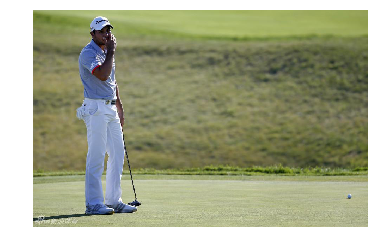

一个 右手 拿 着 高尔夫球 杆 的 男人 站 在 草地 上 </S> 0.10867
probs [0.7038826490853338, 0.27684906761996614, 0.9211275285491622, 0.9978911145968743, 0.5138548739889304, 0.9675724089177673, 0.9987730554894643, 0.6635849279380265, 0.9084971007534596, 0.9993669228968524, 0.27841299121404905, 0.9981124334566663, 0.9926203764143897, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


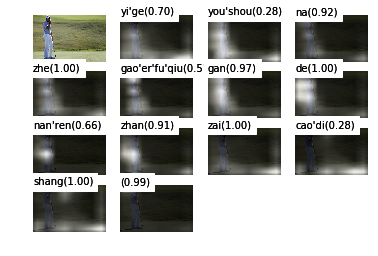

beam search using time(ms): 4573.51994514
一个 左手 拿 着 球杆 的 男人 站 在 高尔夫球场 上 </S> 0.102944
probs [0.7038826490853338, 0.26759176171853255, 0.8953108689695496, 0.9978717655400365, 0.5249108505654895, 0.9685415388416267, 0.7548056338338363, 0.8331082762151297, 0.9991582570745248, 0.27312249816810985, 0.9981986604598749, 0.9914488415083547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


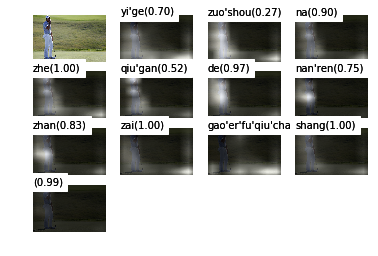

beam search using time(ms): 1414.96801376
一个 左手 拿 着 高尔夫球 杆 的 男人 站 在 草地 上 </S> 0.0986487
probs [0.7038826490853338, 0.26759176171853255, 0.8953108689695496, 0.9978717655400365, 0.46649864332748125, 0.9965840836730053, 0.9983608217208424, 0.5682686539580513, 0.9038812269106844, 0.9993870441502437, 0.31071119555600296, 0.9985276712770752, 0.9889236324943338, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


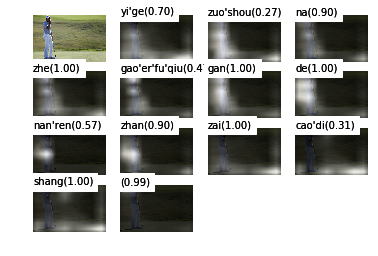

beam search using time(ms): 1761.9600296
一个 戴着 帽子 的 人 拿 着 高尔夫球 杆站 在 郁郁葱葱 的 草地 上 </S> 0.0984728
probs [0.7038826490853338, 0.22066144309143831, 0.9252413333922604, 0.9068238993018503, 0.42294554671620077, 0.6715690534413681, 0.9960271040249407, 0.9080129808588365, 0.5755580127991018, 0.9966554818722362, 0.5731996252027587, 0.9994331237049913, 0.9511338788054764, 0.9989151815080277, 0.9991926517704652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


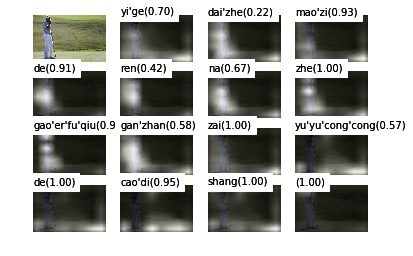

beam search using time(ms): 2086.86685562
一个 右手 拿 着 球杆 的 男人 站 在 高尔夫球场 上 </S> 0.0936425
probs [0.7038826490853338, 0.27684906761996614, 0.9211275285491622, 0.9978911145968743, 0.4736047509000201, 0.9903768747640597, 0.8120430806636032, 0.8356094413220121, 0.9987878013913517, 0.21562168297678622, 0.9985475210536962, 0.9936095212664757, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


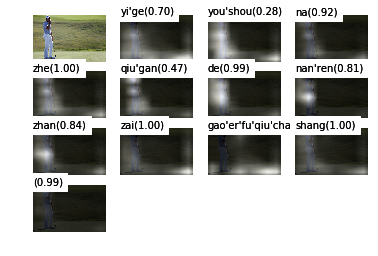

beam search using time(ms): 2067.79193878
一个 右手 拿 着 球杆 的 男人 站 在 球场上 </S> 0.0856925
probs [0.7038826490853338, 0.27684906761996614, 0.9211275285491622, 0.9978911145968743, 0.4736047509000201, 0.9903768747640597, 0.8120430806636032, 0.8356094413220121, 0.9987878013913517, 0.21118355302794256, 0.9476311346583399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


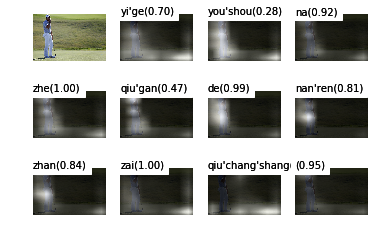

beam search using time(ms): 1483.62803459
一个 右手 拿 着 高尔夫球 杆 的 男人 站 在 碧绿 的 草地 上 </S> 0.0849728
probs [0.7038826490853338, 0.27684906761996614, 0.9211275285491622, 0.9978911145968743, 0.5138548739889304, 0.9675724089177673, 0.9987730554894643, 0.6635849279380265, 0.9084971007534596, 0.9993669228968524, 0.15932205283606968, 0.9994848046206039, 0.9172832906934743, 0.9996141492566889, 0.9985362290749085, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


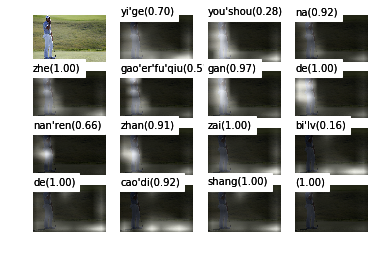

beam search using time(ms): 1938.27915192
一个 戴着 帽子 的 男人 站 在 高尔夫球场 上 </S> 0.0841932
probs [0.7038826490853338, 0.22066144309143831, 0.9252413333922604, 0.9068238993018503, 0.4711427964467689, 0.41526657930005967, 0.9986213404876176, 0.5101741823737771, 0.9977524839170275, 0.9467078652446591, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


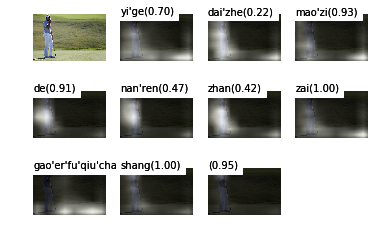

beam search using time(ms): 1235.18681526
一个 右手 拿 着 球杆 的 男人 站 在 绿茵茵 的 球场上 </S> 0.0738528
probs [0.7038826490853338, 0.27684906761996614, 0.9211275285491622, 0.9978911145968743, 0.4736047509000201, 0.9903768747640597, 0.8120430806636032, 0.8356094413220121, 0.9987878013913517, 0.19246387254271063, 0.999979258013377, 0.6509383558403903, 0.9952326498195528, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


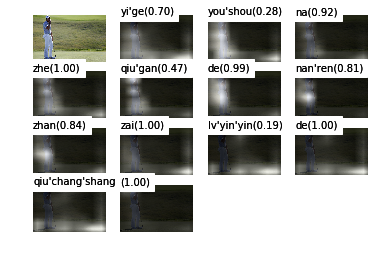

beam search using time(ms): 1679.64816093
一个 左手 拿 着 高尔夫球 杆 的 男人 站 在 碧绿 的 草地 上 </S> 0.0727445
probs [0.7038826490853338, 0.26759176171853255, 0.8953108689695496, 0.9978717655400365, 0.46649864332748125, 0.9965840836730053, 0.9983608217208424, 0.5682686539580513, 0.9038812269106844, 0.9993870441502437, 0.15623927474260552, 0.9994069281132797, 0.9217358196574639, 0.999640593995036, 0.9976513840009857, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


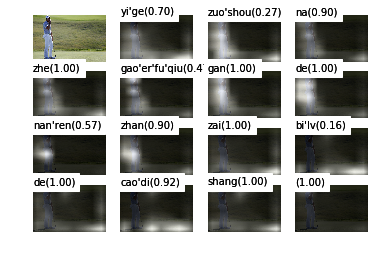

beam search using time(ms): 1939.63694572


KeyboardInterrupt: 

In [8]:
while True:
  image_name = raw_input('image_name like 6275b5349168ac3fab6a493c509301d023cf39d3.jpg: ')
  image_name = image_name.strip().replace('file://', '')
  if image_name == 'q':
    break
  if not image_name.endswith('.jpg'):
    image_name += '.jpg'

  image_path = os.path.join(image_dir, image_name)

  if not os.path.exists(image_path):
    print('path not exists:%s'%image_path)
    image_path = image_name
    if not os.path.exists(image_path):
        continue
  plt.subplot(1, 1, 1)
  image_show(image_path)
  predict(image_path, predictor)
  #predict(image_path, predictor2, gen_feature=False)

In [ ]:
import glob 
for img in glob.glob('/home/gezi/new2/data/ai_challenger/image_caption/test_pic/*.jpg'):
    image_show(img)
    predict(img, predictor)